In [74]:
import numpy as np
import matplotlib.pyplot as plt
from pactools import Comodulogram, REFERENCES
import pandas as pd
import seaborn as sns
import sys
sys.path.append('/Users/yat-lok/workspaces/tvbtools/')
from tools.signaltools import SignalToolkit
from scipy.signal import decimate

In [80]:
df = pd.read_excel('/Users/yat-lok/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
groups = ['SNC', 'NC', 'MCI', 'AD']

def comodulograms(signal, fs=819, low_fq_width=1.0, low_fq_range=np.linspace(1,10,50), methods='duprelatour'):
    # Compute the comodulograms and plot them
    print('%s... ' % (methods, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                                low_fq_width=low_fq_width, method=methods,
                                progress_bar=False)
    estimator.fit(signal)
    # estimator.plot()
    return estimator.comod_

collect_left = np.empty((50, 80, len(df['group'])))
collect_right = np.empty((50, 80, len(df['group'])))

index=0

for grp, sbj, gc in zip(df['group'], df['caseid'],df['Gc']):
    try:
        path = '/Users/yat-lok/workspaces/data4project/lateralization/LFP_critical/'+grp+'/'+sbj+'_'+str(gc)+'.csv'
        single_sim = pd.read_csv(path)
        signal_left = single_sim['pCNG-L']
        signal_left_down = decimate(signal_left, 100)
        signal_left_filtered = SignalToolkit.sos_filter(signal_left_down, win=[0.5, 400], fs=819)

        signal_right = single_sim['pCNG-R']
        signal_right_down = decimate(signal_right, 100)
        signal_right_filtered = SignalToolkit.sos_filter(signal_right_down, win=[0.5, 400], fs=819)
        collect_left[:,:,index] = comodulograms(signal_left_filtered)
        collect_right[:,:,index] = comodulograms(signal_right_filtered)
        index+=1
    except FileNotFoundError:
        continue

duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelatour... 
duprelat

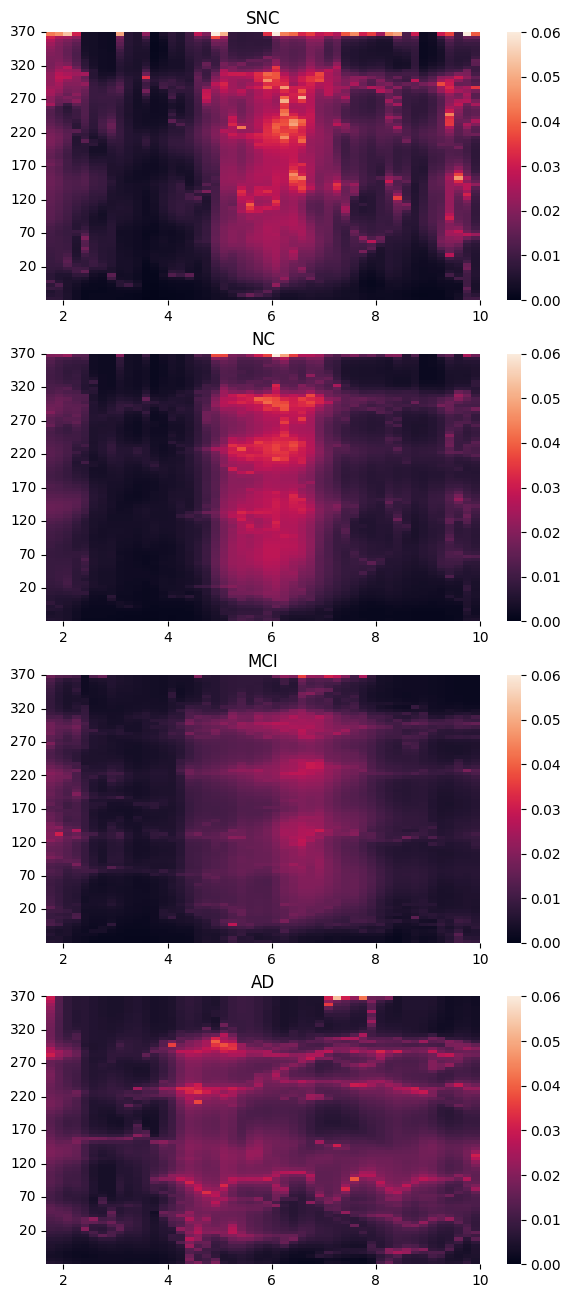

In [88]:
SNC = 10
NC = 10+16
MCI = 10+16+35

diff_collect = collect_left

SNC_diff = np.mean(diff_collect[:,:,:SNC], axis=2)
NC_diff = np.mean(diff_collect[:,:,:NC], axis=2) 
MCI_diff = np.mean(diff_collect[:,:,NC:MCI], axis=2)
AD_diff = np.mean(diff_collect[:,:,MCI:], axis=2)


# SNC_diff = np.mean(collect_left[:,:,:SNC], axis=2) - np.mean(collect_right[:,:,:SNC], axis=2)
# NC_diff = np.mean(collect_left[:,:,SNC:NC], axis=2) - np.mean(collect_right[:,:,SNC:NC], axis=2)
# MCI_diff = np.mean(collect_left[:,:,NC:MCI], axis=2) - np.mean(collect_right[:,:,NC:MCI], axis=2)
# AD_diff = np.mean(collect_left[:,:,MCI:], axis=2) - np.mean(collect_right[:,:,MCI:], axis=2)

title = ['SNC', 'NC', 'MCI', 'AD']

def pac_plot(matrix, title, index):
    sns.heatmap(matrix.T,vmin = 0, vmax=0.06, ax=axs[index])
    axs[index].invert_yaxis()
    axs[index].set_title(title)
    # axs[index].set_xlabel('Theta Frequency (Hz)')
    axs[index].set_xticks(np.arange(2, 51, 12))
    axs[index].set_xticklabels(np.arange(2, 11, 2), rotation=0)
    # plt.ylabel('Gamma Frequency (Hz)')
    axs[index].set_yticks(np.arange(10,81,10))
    axs[index].set_yticklabels(np.arange(20,400,50), rotation=0)


summary = [SNC_diff, NC_diff, MCI_diff, AD_diff]
fig, axs = plt.subplots(4,1, figsize=(7,16))
axs = axs.ravel()
for index, i in enumerate(summary):
    pac_plot(i, title[index], index)
plt.show()